In [3]:

import os
import numpy as np
import torch
from torch import nn
from scipy.stats import ortho_group
from typing import Union
from typing_extensions import Literal
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from torchvision.datasets import MNIST
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 10000 if AVAIL_GPUS else 64
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.linalg import block_diag
from sklearn.linear_model import LinearRegression
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

## Standard MCC

In [4]:
def MCC(Z,Zp):
    n = np.shape(Z)[1]
    rho_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            rho_matrix[i,j] = np.abs(np.corrcoef(Z[:,i], Zp[:,j])[0,1])
    
    print(rho_matrix)
    r,c = linear_sum_assignment(-rho_matrix)
    
    return np.mean(rho_matrix[r,c])

## Invertible MLP function from CIDGP paper

In [5]:
## Invertible MLP function from CIDGP paper

def construct_invertible_mlp(
    n: int = 20,
    n_layers: int = 2,
    n_iter_cond_thresh: int = 10000,
    cond_thresh_ratio: float = 0.25,
    weight_matrix_init: Union[Literal["pcl"], Literal["rvs"]] = "pcl",
    act_fct: Union[
        Literal["relu"],
        Literal["leaky_relu"],
        Literal["elu"],
        Literal["smooth_leaky_relu"],
        Literal["softplus"],
    ] = "leaky_relu",
):
   
    """
    Create an (approximately) invertible mixing network based on an MLP.
    Based on the mixing code by Hyvarinen et al.
    Args:
        n: Dimensionality of the input and output data
        n_layers: Number of layers in the MLP.
        n_iter_cond_thresh: How many random matrices to use as a pool to find weights.
        cond_thresh_ratio: Relative threshold how much the invertibility
            (based on the condition number) can be violated in each layer.
        weight_matrix_init: How to initialize the weight matrices.
        act_fct: Activation function for hidden layers.
    """

    class SmoothLeakyReLU(nn.Module):
        def __init__(self, alpha=0.2):
            super().__init__()
            self.alpha = alpha

        def forward(self, x):
            return self.alpha * x + (1 - self.alpha) * torch.log(1 + torch.exp(x))

    def get_act_fct(act_fct):
        if act_fct == "relu":
            return torch.nn.ReLU, {}, 1
        if act_fct == "leaky_relu":
            return torch.nn.LeakyReLU, {"negative_slope": 0.2}, 1
        elif act_fct == "elu":
            return torch.nn.ELU, {"alpha": 1.0}, 1
        elif act_fct == "max_out":
            raise NotImplemented()
        elif act_fct == "smooth_leaky_relu":
            return SmoothLeakyReLU, {"alpha": 0.2}, 1
        elif act_fct == "softplus":
            return torch.nn.Softplus, {"beta": 1}, 1
        else:
            raise Exception(f"activation function {act_fct} not defined.")

    layers = []
    act_fct, act_kwargs, act_fac = get_act_fct(act_fct)

    # Subfuction to normalize mixing matrix
    def l2_normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat * Amat, axis))
        Amat = Amat / l2norm
        return Amat
    print (n_iter_cond_thresh)
    condList = np.zeros([n_iter_cond_thresh])
    if weight_matrix_init == "pcl":
        for i in range(n_iter_cond_thresh):
            A = np.random.uniform(-1, 1, [n, n])
            A = l2_normalize(A, axis=0)
            condList[i] = np.linalg.cond(A)
        condList.sort()  # Ascending order
    condThresh = condList[int(n_iter_cond_thresh * cond_thresh_ratio)]
    print("condition number threshold: {0:f}".format(condThresh))

    for i in range(n_layers):

        lin_layer = nn.Linear(n, n, bias=False)

        if weight_matrix_init == "pcl":
            condA = condThresh + 1
            while condA > condThresh:
                weight_matrix = np.random.uniform(-1, 1, (n, n))
                weight_matrix = l2_normalize(weight_matrix, axis=0)

                condA = np.linalg.cond(weight_matrix)
                # print("    L{0:d}: cond={1:f}".format(i, condA))
            print(
                f"layer {i+1}/{n_layers},  condition number: {np.linalg.cond(weight_matrix)}"
            )
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)

        elif weight_matrix_init == "rvs":
            weight_matrix = ortho_group.rvs(n)
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)
        elif weight_matrix_init == "expand":
            pass
        else:
            raise Exception(f"weight matrix {weight_matrix_init} not implemented")

        layers.append(lin_layer)

        if i < n_layers - 1:
            layers.append(act_fct(**act_kwargs))

    mixing_net = nn.Sequential(*layers)

    # fix parameters
    for p in mixing_net.parameters():
        p.requires_grad = False

    return mixing_net

## Data generation function

In [6]:
def data_generation_MLP(n, n_layers, cond_thresh_ratio, n_iter_cond_thresh, n_data, distribution): 
    if(distribution == "uniform_non_linear"): # all components of z are uniform i.i.d.
        data_Z        = np.random.rand(n_data, n)*5.0
        tensor_Z      = torch.Tensor(data_Z)

    if(distribution == "normal_non_linear"): # all components of z are uniform i.i.d.            
        A1 = np.ones((n//2,n//2))
        A2 = np.ones((n//2,n//2))
        A = block_diag(A1,A2)
        data_Z = np.random.multivariate_normal(mean=np.zeros(n), cov=np.eye(n) + A@A.T, size=n_data, check_valid='warn', tol=1e-8)
        tensor_Z      = torch.Tensor(data_Z)

    g = construct_invertible_mlp(n, n_layers,   n_iter_cond_thresh, cond_thresh_ratio)  
    data = g(tensor_Z)
    data_Z_list   = [tensor_Z]
    data_X_list     = [data]
    offset = torch.cat((torch.ones((n_data,1)), torch.ones((n_data,1))), axis=1)
    for i in range(n):
        if(i<=n-2):
            tensor_Z_copy = torch.clone(tensor_Z)
            tensor_Z_copy[:,i:i+2] = tensor_Z_copy[:,i:i+2] + offset
            data_copy = g(tensor_Z_copy)
            data_Z_list.append(tensor_Z_copy)
            data_X_list.append(data_copy)
            data_X_tuple = tuple(data_X_list)
            data_Z_tuple  = tuple(data_Z_list)
        else:
            tensor_Z_copy = torch.clone(tensor_Z)
            tensor_Z_copy[:,n-1] = tensor_Z_copy[:,n-1] + offset[:,0]
            tensor_Z_copy[:,0] = tensor_Z_copy[:,0] + offset[:,1]
            data_copy = g(tensor_Z_copy)
            data_Z_list.append(tensor_Z_copy)
            data_X_list.append(data_copy)
            data_X_tuple = tuple(data_X_list)
            data_Z_tuple  = tuple(data_Z_list)


    return data_X_list, data_Z_list

## Construct the model and loss (compares intervened and default latent)


In [7]:
class Latent_comparison_model(LightningModule):
    def __init__(self,n):
        super().__init__()
        self.n     = n
        num_hidden = 100
        self.linear1 = nn.Linear(self.n, num_hidden)
        self.act_fn1 = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.act_fn2 = nn.ReLU()
        self.linear3 = nn.Linear(num_hidden, self.n)
        offset_matrix = torch.Tensor(np.random.RandomState(1).uniform(1, 5, size=(self.n,2)))
        self.offset_matrix = torch.nn.Parameter(offset_matrix, requires_grad=True)
        
    def forward(self, x):       
        
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)
        
        return x

    def training_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        
        loss   = 0.0
              
        
        for i in range(1,L):
            if(i<=L-2):
                offset = torch.ones((n_d,2))*self.offset_matrix[i-1]
                Z_target  = self(batch_X_list[i])
                Z_predict = self(X_0) 
                Z_predict[:,i-1:i+1] = Z_predict[:,i-1:i+1] + offset 
                loss = loss + F.mse_loss(Z_predict, Z_target)
            else:
                offset = torch.ones((n_d,2))*self.offset_matrix[i-1]
                Z_target  = self(batch_X_list[i])
                Z_predict = self(X_0) 
                Z_predict[:,0]   = Z_predict[:,0] + offset[:,1] 
                Z_predict[:,L-2] = Z_predict[:,L-2] + offset[:,0]
                loss = loss + F.mse_loss(Z_predict, Z_target)

            
        return loss
    
    def validation_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        offset = torch.cat((torch.ones((n_data,1)), torch.ones((n_data,1))), axis=1)
        loss   = 0.0
        for i in range(1,L-1):
            Z_target  = self(batch_X_list[i])
            Z_predict = self(X_0) 
            Z_predict[:,i-1] = Z_predict[:,i-1] + offset 
            loss = loss + F.mse_loss(Z_predict, Z_target)
            
            
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)

In [8]:
n=10
data_X, data_Z = data_generation_MLP(n=n, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="normal_non_linear")
k= len(data_X)
train_data_X = []
test_data_X  = []
train_data_Z = []
test_data_Z  = []
train_size = 10000
for i in range(k):
    train_data_X.append(data_X[i][:train_size])
    train_data_Z.append(data_Z[i][:train_size])
    test_data_X.append(data_X[i][train_size:])
    test_data_Z.append(data_Z[i][train_size:])  

25000
condition number threshold: 3.823613
layer 1/2,  condition number: 3.7329970332366824
layer 2/2,  condition number: 3.676483051784568


## Train model

In [9]:
latent_comparison_model = Latent_comparison_model(n)
train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)

trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=2000,
    progress_bar_refresh_rate=20,
)
trainer.fit(latent_comparison_model, train_loader)

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

Training: 0it [00:00, ?it/s]

## Output MCC and correlation matrix

In [10]:
Zp=latent_comparison_model(test_data_X[0])
Z = test_data_Z[0]
MCC(Z.detach().numpy(),Zp.detach().numpy())

[[0.95056893 0.85640462 0.67319054 0.86880189 0.63419747 0.0506155
  0.1044074  0.36452849 0.10036566 0.08821738]
 [0.75988396 0.99394847 0.77825208 0.81064099 0.74805876 0.03044542
  0.07409823 0.2353338  0.0631116  0.05804326]
 [0.8224138  0.8512081  0.87884032 0.87013193 0.6181342  0.04459452
  0.11438425 0.35031432 0.08824554 0.07262047]
 [0.75990456 0.83100403 0.77953764 0.96016196 0.74870264 0.02460647
  0.0845488  0.22733769 0.05822663 0.04894682]
 [0.82874998 0.85100165 0.66253119 0.86987627 0.83060817 0.04183645
  0.11990141 0.35142024 0.08627299 0.07072339]
 [0.22572623 0.0875264  0.28967539 0.18980412 0.34142367 0.99475192
  0.85799084 0.61060904 0.76155454 0.80195779]
 [0.15009282 0.06088166 0.18448876 0.12937881 0.21416505 0.83012052
  0.98759707 0.74087209 0.80352248 0.83888382]
 [0.22077517 0.08409672 0.28579145 0.18926706 0.33847424 0.81548737
  0.86061503 0.81499973 0.76809076 0.80609898]
 [0.15944783 0.06484712 0.18608971 0.13107335 0.22064058 0.83429103
  0.83162166 

0.9380908207827865

## Linear regression comparing the predicted and true latents

In [25]:
Zp_np = np.array([Zp.detach().numpy()[:,0]]).T
Z_np = np.array([Z.detach().numpy()[:,0]]).T
reg = LinearRegression().fit(Z_np, Zp_np)
m = reg.coef_[0]
b = reg.intercept_[0]
x = Z_np

In [27]:
Zp_np = np.array([Zp.detach().numpy()[:,1]]).T
Z_np = np.array([Z.detach().numpy()[:,1]]).T
reg = LinearRegression().fit(Z_np, Zp_np)
m1 = reg.coef_[0]
b1 = reg.intercept_[0]
x1 = Z_np

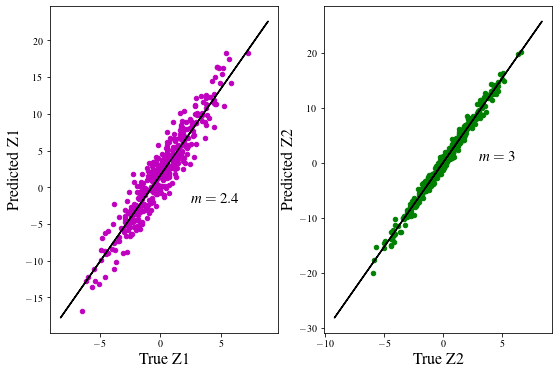

In [39]:
plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.scatter(Z.detach().numpy()[:400,0], Zp.detach().numpy()[:400,0], c='m', s=20)

plt.plot(x, m*x+b, 'k')
plt.xlabel("True Z1", fontsize=16)
plt.ylabel("Predicted Z1", fontsize=16)
plt.text(2.5, -2, r'$m=2.4$',
         fontsize=15)
plt.subplot(1, 2, 2)
plt.scatter(Z.detach().numpy()[:400,1], Zp.detach().numpy()[:400,1], c='g', s=20)

plt.plot(x1, m1*x1+b1, 'k')
plt.xlabel("True Z2", fontsize=16)
plt.ylabel("Predicted Z2", fontsize=16)
plt.text(3, 0.4, r'$m=3$',
         fontsize=15)

plt.savefig("overlap_d12.pdf")


## Generate results

In [ ]:
n_trials=5
dim_list = [6,10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="normal_non_linear")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=4000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
    
    m=m+1
        
    
        

In [15]:
MCC_result

array([[0.94211869, 0.94183405, 0.92964791, 0.93018671, 0.95439786],
       [0.97230094, 0.97695666, 0.97844847, 0.96380652, 0.94925787],
       [0.98802075, 0.99296727, 0.99456586, 0.99163228, 0.99224883]])

In [26]:
MCC_result

array([[0.96358681, 0.95285845, 0.96271743, 0.94744586, 0.94213341],
       [0.98045691, 0.96504597, 0.97452048, 0.96606567, 0.97530899],
       [0.98035716, 0.99050753, 0.99079972, 0.994346  , 0.99295047]])

In [41]:
MCC_result = np.array([[0.96358681, 0.95285845, 0.96271743, 0.94744586, 0.94213341],
       [0.98045691, 0.96504597, 0.97452048, 0.96606567, 0.97530899],
       [0.98035716, 0.99050753, 0.99079972, 0.994346  , 0.99295047]])

In [42]:
print ([np.std(MCC_result[i,:]) for i in range(3)])

[0.00839833107971913, 0.005865244663342191, 0.004924602261927776]


In [19]:
n_trials=5
dim_list = [6,10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="uniform_non_linear")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=2000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
    
    m=m+1
        
    

25000
condition number threshold: 2.128932
layer 1/2,  condition number: 1.9409605628851925


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.9477018439787184


Training: 0it [00:00, ?it/s]

[[0.89424354 0.2716287  0.18915048 0.25375003 0.21809566 0.04526426]
 [0.19215332 0.80018129 0.20407233 0.25920087 0.21906551 0.04379405]
 [0.19682605 0.28682517 0.91370519 0.25964981 0.20825808 0.04443099]
 [0.18601861 0.27600626 0.186689   0.81249752 0.22512428 0.04209682]
 [0.19640403 0.26771399 0.18212697 0.26278398 0.87791197 0.02583368]
 [0.19927526 0.27083121 0.17402742 0.26747533 0.22816087 0.99557407]]
25000
condition number threshold: 2.104319
layer 1/2,  condition number: 2.0386668041894254


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 2.0588176175430593


Training: 0it [00:00, ?it/s]

[[0.89665524 0.08214493 0.14289889 0.06302774 0.30357311 0.37807876]
 [0.21984718 0.97559741 0.15286875 0.027189   0.30659273 0.3880884 ]
 [0.20361273 0.1052983  0.94305812 0.06961598 0.28249641 0.38149729]
 [0.20568507 0.11686636 0.16211906 0.99225709 0.31096741 0.38897231]
 [0.20679256 0.10383712 0.11206386 0.07045641 0.73719807 0.42101476]
 [0.19843875 0.09711835 0.11859054 0.06738551 0.33207079 0.49695625]]
25000
condition number threshold: 2.153919
layer 1/2,  condition number: 2.0500215284561287


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 2.1180870910207767


Training: 0it [00:00, ?it/s]

[[0.79412589 0.31697812 0.08710821 0.03285695 0.17341456 0.38019841]
 [0.26271065 0.69125284 0.0890408  0.03013336 0.1962708  0.37164606]
 [0.28435097 0.32658007 0.97255583 0.03338802 0.21588368 0.3393771 ]
 [0.27120942 0.32223827 0.10842797 0.99783322 0.18049247 0.38953895]
 [0.25577205 0.33402874 0.07380066 0.03142772 0.91193519 0.35428493]
 [0.2976388  0.32114149 0.12206839 0.02568722 0.19634774 0.55826491]]
25000
condition number threshold: 1.792060
layer 1/2,  condition number: 1.720414452763104


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.7799283095362042


Training: 0it [00:00, ?it/s]

[[0.71676704 0.10380684 0.11028212 0.10777899 0.26663639 0.15867651]
 [0.30088573 0.97107241 0.11370763 0.13684699 0.26296533 0.15333915]
 [0.30362442 0.11098486 0.96991848 0.14127865 0.24474901 0.14508897]
 [0.29527688 0.1239805  0.13103615 0.96253383 0.24731766 0.15105864]
 [0.32147587 0.12083901 0.10579526 0.11640841 0.82187112 0.15337565]
 [0.31520563 0.10965653 0.10412361 0.11969689 0.25380486 0.93893388]]
25000
condition number threshold: 1.955830
layer 1/2,  condition number: 1.9273036335973195


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.9418240652907386


Training: 0it [00:00, ?it/s]

[[0.71803878 0.0810709  0.07510296 0.08465548 0.40791482 0.17154929]
 [0.29485481 0.97280001 0.08646502 0.07700668 0.37864955 0.17854818]
 [0.29421787 0.09407344 0.97419792 0.07961211 0.38942924 0.17431834]
 [0.30696471 0.1026732  0.09471667 0.98789297 0.38781501 0.16798867]
 [0.33158217 0.09184362 0.09734877 0.07238622 0.52745574 0.16901536]
 [0.30830463 0.10718478 0.0960757  0.07815178 0.37801746 0.92336446]]
25000
condition number threshold: 4.015113
layer 1/2,  condition number: 3.7851360520777897
layer 2/2,  condition number: 3.7768743515900107


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[[0.94100802 0.182982   0.28113737 0.0126464  0.02878231 0.05235002
  0.09083901 0.21469423 0.27534546 0.05128974]
 [0.09136789 0.81855405 0.277059   0.03648725 0.02463203 0.03559312
  0.11104877 0.24102022 0.27609925 0.06569122]
 [0.10786326 0.15859162 0.52738971 0.03482926 0.03874318 0.02562477
  0.10292611 0.22725374 0.24995451 0.05433698]
 [0.10266618 0.1920044  0.294975   0.99569451 0.0232144  0.03800722
  0.10330801 0.22359444 0.2369668  0.03583344]
 [0.11415835 0.18722283 0.29125981 0.01558498 0.99505813 0.03440261
  0.0714299  0.2478817  0.22465813 0.08984222]
 [0.09007478 0.18384035 0.29181901 0.02644873 0.03295301 0.99542138
  0.10750709 0.21413244 0.2554433  0.03430383]
 [0.12143942 0.19232948 0.27823445 0.01483665 0.0531937  0.05226633
  0.96235845 0.23290874 0.24478879 0.06901316]
 [0.09019532 0.18924543 0.26940955 0.02565058 0.05202453 0.03819283
  0.08366324 0.74304265 0.24423542 0.03782779]
 [0.14067711 0.20573519 0.27884056 0.01867742 0.00788089 0.01407096
  0.09699026

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 4.089118077526547


Training: 0it [00:00, ?it/s]

[[8.35182813e-01 1.54753678e-02 1.07356590e-01 2.13215950e-01
  4.12635043e-03 6.39587187e-02 1.00398090e-01 2.07819020e-01
  2.15289798e-02 1.03694946e-01]
 [1.77391916e-01 9.97688413e-01 7.41632099e-02 2.17665574e-01
  1.35815842e-03 5.61151023e-02 1.30295976e-01 2.02080238e-01
  2.81565984e-02 1.04100400e-01]
 [2.08184751e-01 1.31819714e-02 9.69313527e-01 2.02295357e-01
  3.00443743e-03 4.28212974e-02 7.86590327e-02 2.51013069e-01
  1.29069329e-02 1.17720478e-01]
 [1.86779949e-01 2.93246335e-02 6.49387400e-02 7.56531152e-01
  1.99136505e-02 4.87439541e-02 1.05123350e-01 2.50368240e-01
  3.32031902e-02 8.18864130e-02]
 [1.88910995e-01 1.97729171e-02 9.64330230e-02 2.10258892e-01
  9.99903299e-01 5.33379844e-02 1.25345396e-01 2.31674874e-01
  2.64911362e-04 8.93336867e-02]
 [1.83287323e-01 3.39854647e-02 6.12641976e-02 2.05887736e-01
  5.09302266e-03 9.86925396e-01 1.07433494e-01 2.36245997e-01
  1.15884383e-02 1.35046926e-01]
 [1.74872974e-01 4.58262258e-02 5.13826923e-02 2.08403451e

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.885522395992318


Training: 0it [00:00, ?it/s]

[[0.99980079 0.06426761 0.18082151 0.24696036 0.18825806 0.21106209
  0.18118331 0.04777085 0.0186643  0.09837069]
 [0.01077344 0.99019259 0.18597158 0.23988252 0.16963212 0.19732825
  0.18054833 0.05349184 0.01950347 0.07700069]
 [0.00601623 0.07125056 0.86042242 0.23726356 0.17529916 0.16786895
  0.20923153 0.08325235 0.01459518 0.11431453]
 [0.01080459 0.04525144 0.16716793 0.65449852 0.2041504  0.19570124
  0.20498669 0.04646518 0.0184337  0.11125896]
 [0.00518686 0.04360851 0.16656298 0.26013094 0.84242114 0.21845084
  0.19641744 0.06806432 0.00905518 0.12986018]
 [0.00585733 0.04328271 0.13188082 0.23759089 0.19825944 0.7731504
  0.19689415 0.070245   0.00716955 0.09277277]
 [0.01276803 0.04798553 0.19032067 0.25242313 0.18563496 0.20812556
  0.82109296 0.04803486 0.00578119 0.10623522]
 [0.01409369 0.04598033 0.18954714 0.23521273 0.18772437 0.2140235
  0.17337956 0.98488376 0.00419215 0.09037419]
 [0.00157009 0.04637892 0.16727685 0.2421008  0.18147415 0.21329123
  0.1928096  0

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 4.20802508043607


Training: 0it [00:00, ?it/s]

[[0.69469567 0.06433393 0.11959073 0.1567286  0.0435163  0.10194872
  0.17852417 0.16857425 0.03824237 0.12787774]
 [0.254152   0.97444185 0.11338922 0.15842025 0.02753913 0.08159073
  0.18649809 0.20209947 0.02527637 0.1071109 ]
 [0.21100601 0.10231863 0.89516894 0.15771002 0.0172057  0.14414037
  0.15266234 0.1688683  0.05233555 0.12731976]
 [0.23918737 0.08172634 0.16090708 0.88011352 0.06083737 0.12658383
  0.1718524  0.22701274 0.00170361 0.0915488 ]
 [0.23325645 0.07119722 0.16572783 0.13377507 0.99516695 0.09077306
  0.18333872 0.19553177 0.03314941 0.10953013]
 [0.2427285  0.09977765 0.1951728  0.17289025 0.05013982 0.94791463
  0.1501625  0.18028916 0.04253659 0.10699657]
 [0.24798137 0.07074398 0.13554776 0.15940616 0.02643149 0.08176669
  0.85571603 0.17619942 0.02762402 0.12831319]
 [0.23471604 0.06681932 0.14545901 0.19614603 0.02910409 0.10033465
  0.16178549 0.82778713 0.00812098 0.08829017]
 [0.24694411 0.07807299 0.17039487 0.13943575 0.02547291 0.12271551
  0.17148329

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.5792205230733436


Training: 0it [00:00, ?it/s]

[[0.93116834 0.16260125 0.30261816 0.23303091 0.02301519 0.18690926
  0.17134399 0.04890052 0.07409973 0.07824106]
 [0.11011563 0.8696062  0.30384163 0.25693223 0.04253004 0.21012933
  0.18101928 0.05654684 0.03233384 0.06106431]
 [0.09025935 0.13805696 0.36099454 0.23553096 0.03106685 0.19312698
  0.17079626 0.05606806 0.05582357 0.02556688]
 [0.11376352 0.17416209 0.30653353 0.67555164 0.03034974 0.17654882
  0.17869391 0.06750864 0.08562824 0.07824254]
 [0.11728618 0.15724932 0.31015372 0.25379261 0.994669   0.22664925
  0.20141739 0.09740673 0.04341857 0.08079878]
 [0.12795702 0.17901303 0.32270262 0.23250807 0.02396989 0.78905943
  0.15232816 0.0632402  0.06698778 0.08678967]
 [0.12260431 0.17376664 0.31703402 0.25864091 0.01976536 0.18595432
  0.84586299 0.06413074 0.06106722 0.08972875]
 [0.09832585 0.17667493 0.30518992 0.23420625 0.05981351 0.20632776
  0.17856597 0.97639169 0.05829821 0.0638145 ]
 [0.1025476  0.13703474 0.31477361 0.26894231 0.04266088 0.21147605
  0.18326715

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 9.377591285119049


Training: 0it [00:00, ?it/s]

[[9.32924601e-01 6.53407100e-02 1.54598974e-01 7.83475322e-02
  1.29651972e-01 8.69638393e-02 9.46739208e-02 1.98085048e-01
  1.05922191e-01 1.59900302e-02 8.95562210e-02 1.73992082e-01
  2.05765033e-01 1.30765262e-02 8.95276889e-02 6.00578705e-03
  1.02135541e-01 1.35750384e-01 1.14707251e-01 9.82472271e-02]
 [6.26890344e-02 9.75226398e-01 1.70496117e-01 3.69075409e-02
  1.70864926e-01 8.14622747e-02 1.41869915e-01 2.27656288e-01
  6.40378895e-02 4.17488350e-03 1.09482092e-01 1.48280933e-01
  1.80566931e-01 1.59970800e-02 9.51348225e-02 1.70090689e-02
  6.25832539e-02 1.22697795e-01 1.45045763e-01 9.58196396e-02]
 [3.71368408e-02 4.62309909e-03 9.06273822e-01 7.19021285e-03
  1.20161177e-01 1.02758312e-01 1.16405572e-01 2.18045745e-01
  5.82407441e-02 9.21247014e-03 8.12938566e-02 1.06462163e-01
  2.16932851e-01 1.64041028e-02 8.40455802e-02 4.28989238e-02
  6.23950847e-02 8.11973863e-02 1.10838896e-01 1.11493874e-01]
 [5.50650500e-02 1.34240369e-02 8.46469638e-02 9.22299471e-01
  1.2

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 7.611972532034463


Training: 0it [00:00, ?it/s]

[[9.38275059e-01 1.86989034e-01 2.83936000e-01 1.02420789e-01
  1.71763483e-02 3.05290882e-04 1.75072479e-01 4.24376555e-02
  1.15244846e-01 2.33831736e-01 1.59649344e-01 1.98883195e-01
  3.71318511e-04 1.68243431e-01 6.90572747e-02 8.30496186e-03
  6.54470469e-02 2.02112478e-01 1.84078256e-01 1.01343063e-01]
 [1.11006168e-01 7.92964650e-01 3.30070006e-01 8.51775993e-02
  2.59688190e-02 7.56163348e-03 1.47385154e-01 3.01711498e-02
  1.28690803e-01 2.09772563e-01 1.15857642e-01 2.08113919e-01
  3.84162166e-02 1.75909965e-01 9.16536760e-02 5.86258333e-02
  6.77904211e-02 1.92865260e-01 1.89894292e-01 7.94324642e-02]
 [1.09488974e-01 1.68170904e-01 4.25987261e-01 6.02735322e-02
  5.50012539e-02 4.52959429e-02 1.54961774e-01 1.82477180e-02
  8.54731767e-02 1.97866358e-01 1.20498512e-01 2.41101476e-01
  7.42063284e-02 1.73781797e-01 1.26592064e-01 7.50829881e-02
  6.10897323e-02 1.54506667e-01 1.64117951e-01 5.70205023e-02]
 [7.44231586e-02 1.28245653e-01 1.89630511e-01 9.31606243e-01
  6.7

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 9.139152461769887


Training: 0it [00:00, ?it/s]

[[0.69459385 0.11292291 0.07431769 0.29054763 0.27347727 0.23470585
  0.11218368 0.14432112 0.1666967  0.12205465 0.02226784 0.02431027
  0.08247914 0.08634596 0.21740387 0.05617988 0.104381   0.18971345
  0.12547987 0.08624806]
 [0.24133479 0.98192811 0.08012565 0.28338791 0.2686312  0.24907636
  0.14351664 0.12156569 0.12131413 0.10048626 0.00955246 0.04579429
  0.06798851 0.05290976 0.18943981 0.0305555  0.13924101 0.16662835
  0.0685933  0.06051777]
 [0.23252887 0.01570547 0.93361379 0.28284264 0.25709863 0.22486763
  0.18354195 0.13489651 0.12143197 0.15625315 0.05007484 0.09278199
  0.05560892 0.07663699 0.19485802 0.02306899 0.15962496 0.14659645
  0.00884963 0.04075098]
 [0.18786124 0.00633794 0.09731683 0.69217922 0.24516191 0.26348729
  0.23245397 0.12836719 0.11145959 0.20618451 0.06179528 0.1012669
  0.00338757 0.10547774 0.18280892 0.00452731 0.17848989 0.13286493
  0.01452507 0.0149061 ]
 [0.2596919  0.02183311 0.11057279 0.08427795 0.360283   0.2825222
  0.24246175 0.152

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.005577264075626


Training: 0it [00:00, ?it/s]

[[4.72383873e-01 2.65307078e-01 6.96157711e-03 1.26071137e-01
  3.07151273e-02 1.42679394e-01 9.89645840e-02 1.78209159e-01
  2.64494659e-02 6.23744288e-02 8.85019247e-02 7.55179053e-02
  7.13674775e-02 4.83593103e-02 6.45013052e-02 2.13052140e-02
  1.51611268e-02 1.66858970e-01 2.35714599e-01 1.58554511e-01]
 [4.18475659e-02 6.93687707e-01 3.71296160e-02 2.11106856e-01
  3.90403600e-02 1.81399417e-01 1.14551458e-01 2.26872206e-01
  1.93129070e-02 6.27450026e-02 1.28593296e-01 6.84556997e-02
  6.86109358e-02 1.00011944e-01 1.32005119e-01 2.03148411e-02
  4.38221885e-02 1.14945126e-01 1.29679533e-01 1.37752259e-01]
 [4.37011943e-03 3.84219061e-01 8.17249871e-01 2.43955050e-01
  1.45744501e-02 2.55711589e-01 5.53211819e-02 8.69692917e-02
  2.69302113e-02 1.10725062e-01 1.58351614e-01 2.21898678e-02
  3.20241588e-02 7.45934034e-02 1.51641320e-01 1.09402600e-01
  1.06198934e-01 6.35076784e-02 1.32155663e-01 1.33087650e-01]
 [7.64611309e-03 3.35391106e-01 2.01032462e-01 8.99955333e-01
  2.6

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn1 | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.754714234534141


Training: 0it [00:00, ?it/s]

[[9.71656777e-01 3.32768188e-01 4.19706089e-02 1.49268395e-01
  2.40629887e-02 1.09683439e-01 4.52681502e-02 1.09363458e-01
  5.95152669e-03 9.53901977e-02 1.53540237e-01 8.14668179e-02
  1.17526747e-01 4.44087920e-02 2.41134864e-01 7.04657545e-02
  2.34665009e-01 4.64253816e-03 3.24992587e-02 1.65442697e-01]
 [6.02558736e-02 6.90374916e-01 3.52700865e-02 2.16809068e-01
  2.89274920e-02 1.10972455e-01 6.55111252e-02 1.03361768e-01
  9.01189169e-03 9.48601756e-02 1.98019819e-01 3.73585728e-02
  6.96022730e-02 5.66506214e-02 1.78715545e-01 3.10601110e-02
  2.12717733e-01 7.10442274e-03 3.58342253e-02 1.81043540e-01]
 [6.43393804e-02 1.34578525e-01 4.50203782e-01 3.06283571e-01
  2.21106334e-02 6.82836452e-02 2.98103774e-02 4.69040001e-02
  1.08415378e-02 8.70148566e-02 2.48091825e-01 3.79099419e-02
  4.37865477e-03 6.11449015e-02 1.44517930e-01 8.66652372e-03
  1.55984646e-01 2.68670994e-03 1.34870865e-01 2.43395938e-01]
 [2.42231328e-02 7.59891362e-02 4.08998775e-01 7.72675699e-01
  1.4

In [20]:
MCC_result

array([[0.88235226, 0.84028703, 0.82099465, 0.89684946, 0.85062498],
       [0.86519599, 0.91923757, 0.88751132, 0.9009809 , 0.8408123 ],
       [0.84133735, 0.82661441, 0.82759512, 0.75640451, 0.80839345]])

In [43]:
MCC_result = np.array([[0.88235226, 0.84028703, 0.82099465, 0.89684946, 0.85062498],
       [0.86519599, 0.91923757, 0.88751132, 0.9009809 , 0.8408123 ],
       [0.84133735, 0.82661441, 0.82759512, 0.75640451, 0.80839345]])

In [44]:
print ([np.std(MCC_result[i,:]) for i in range(3)])

[0.027711382365367895, 0.027398147993651388, 0.02973654580075663]
